In [1573]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.utils import resample
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [1574]:
# removing extra comma in cycling dataset9.csv and cycling dataset14.csv manually as suggested on piazza
# bending2 dataset4.csv space separated (delimitter/sep_)
# https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
path = '../../data/AReM/'
actv_dir = ['bending1', 'bending2']
actv_dir2 = ['bending1','bending2','cycling', 'lying', 'sitting', 'standing', 'walking']
features = ['mean_', 'std_', 'min_', 'first_quartile_', 'median_', 'third_quartile_','max_']
columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']




In [1575]:


def train_test_data():
    train_set = []
    test_set = []
    all_set = []
    # scanning bottom-to-up
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            # Split the path in root and ext pair
            root_ext = os.path.splitext(name)
            # checking the extension
            root_val = root_ext[1]
            if root_val.endswith('.csv'):
                # https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
                file_path = os.path.join(root+ '/' +name)
                # print(file_path)
                # print(file_path)
                my_path = os.path.split(root)
                feature_act = my_path[-1] #to get just the activity name
                # my_path = Path(path)
                # activity = my_path.stem
                regex = '\d+'
                match = re.findall(regex, name)
                # for bending 1 and 2 and dataset 1,2 and 3
                # https://docs.python.org/3/library/stdtypes.html#str.find
                match_activity = int(match[0])
                bool1 = name.find('dataset1.csv')!= -1
                bool2 = name.find('dataset2.csv')!=-1
                bool3 = name.find('dataset3.csv')!=-1
                
                if root.find('bending') != -1:
                    if (bool1 or bool2):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
                # dataset 1,2 and 3
                    # bool2 = match_activity == 3 and feature_act not in actv_dir
                else:
                    if (bool1 or bool2 or bool3):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
    return train_set, test_set, all_set
train_set, test_set, all_set = train_test_data()

In [1576]:
train_set

['../../data/AReM/bending1/dataset7.csv',
 '../../data/AReM/bending1/dataset6.csv',
 '../../data/AReM/bending1/dataset4.csv',
 '../../data/AReM/bending1/dataset5.csv',
 '../../data/AReM/bending1/dataset3.csv',
 '../../data/AReM/walking/dataset7.csv',
 '../../data/AReM/walking/dataset6.csv',
 '../../data/AReM/walking/dataset4.csv',
 '../../data/AReM/walking/dataset5.csv',
 '../../data/AReM/walking/dataset10.csv',
 '../../data/AReM/walking/dataset11.csv',
 '../../data/AReM/walking/dataset13.csv',
 '../../data/AReM/walking/dataset12.csv',
 '../../data/AReM/walking/dataset15.csv',
 '../../data/AReM/walking/dataset14.csv',
 '../../data/AReM/walking/dataset8.csv',
 '../../data/AReM/walking/dataset9.csv',
 '../../data/AReM/bending2/dataset6.csv',
 '../../data/AReM/bending2/dataset4.csv',
 '../../data/AReM/bending2/dataset5.csv',
 '../../data/AReM/bending2/dataset3.csv',
 '../../data/AReM/standing/dataset7.csv',
 '../../data/AReM/standing/dataset6.csv',
 '../../data/AReM/standing/dataset4.csv'

In [1577]:
feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
features = [name+str(i) for i in range(1,7) for name in feature_names]
features.append('activity')
column_names = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

In [1578]:
# https://stackoverflow.com/questions/18366797/pandas-read-csv-how-to-skip-comment-lines
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list

all_csv_files = glob.glob('../../data/AReM/*/*.csv', recursive=True)
# print(all_csv_files)
sniffer = csv.Sniffer()
def load_data(data, features, splits=1):
    sniffer = csv.Sniffer()
    all_data = pd.DataFrame(columns=features)
    
    for csv_files in data:
        
        # Get the delimiter in the CSV file
        root = os.path.dirname(csv_files)
        my_path = os.path.split(root)
        feat_act = my_path[-1]
        # print(feat_act)
        sep_ = sniffer.sniff(open(csv_files).readlines()[6])
        # sep_ = sniffer.sniff(open(csv).read())
        delimiter = sep_.delimiter
        if delimiter == ',':
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
        else:
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
            # print(df)
            df = df.drop([7], axis=1)
        df = df.drop([0], axis=1)
        # finding length of each split
        split_length = int(df.shape[0]/splits)
        train_test_seg = []
        for idx, col in enumerate(df.columns):
            for j in range(splits):
                data = df[j*split_length : min((j+1)*split_length,df.shape[0])]
                train_test_seg.extend([np.min(data[col]),np.max(data[col]),np.mean(data[col]),np.median(data[col]),
                            np.std(data[col]),np.percentile(data[col],25),np.percentile(data[col], 75)])
        train_test_seg.append(feat_act)   
        df_new = pd.Series(train_test_seg, index = features)
        all_data = all_data.append(df_new, ignore_index=True)
    return all_data

In [1579]:
new_columns = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
activity = [stat + str(i) for i in range(1, 7) for stat in new_columns]
# train set
new_train_set = load_data(train_set, features)
print('')
print('Train set is: ')
print(new_train_set)
print('')
new_test_set = load_data(test_set, features)
print('Test set is: ')
# test_stats.isnull().any()
print(new_test_set)


Train set is: 
     min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.25  48.00  43.969125    44.50  1.616677          43.3100   
1   37.00  48.00  43.454958    43.25  1.384653          42.5000   
2   33.00  47.75  42.179812    43.50  3.666840          39.1500   
3   33.00  45.75  41.678063    41.75  2.241152          41.3300   
4   35.00  47.40  43.954500    44.33  1.557210          43.0000   
..    ...    ...        ...      ...       ...              ...   
64  18.50  44.25  35.752354    36.00  4.609992          33.0000   
65  24.25  45.00  37.177042    36.25  3.577569          34.5000   
66  23.33  43.50  36.244083    36.75  3.818032          33.4575   
67  26.25  44.25  36.957458    36.29  3.431283          34.5000   
68  27.75  44.67  37.144833    36.33  3.754986          34.0000   

    third_quartile1  min2   max2     mean2  ...  first_quartile5  \
0             44.67   0.0   1.50  0.413125  ...          20.5000   
1             45.00   0.0   1.58  0.378083 

In [1580]:
new_all_set = load_data(all_set, features)
new_all_set

,min1,max1,mean1,median1,sd1,first_quartile1,third_quartile1,min2,max2,mean2,...,first_quartile5,third_quartile5,min6,max6,mean6,median6,sd6,first_quartile6,third_quartile6,activity
0,36.25,48.00,43.969125,44.50,1.616677,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487318,0.0000,0.8300,bending1
1,37.00,48.00,43.454958,43.25,1.384653,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.621885,0.4300,0.8700,bending1
2,33.00,47.75,42.179812,43.50,3.666840,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.523771,0.0000,1.0000,bending1
3,33.00,45.75,41.678063,41.75,2.241152,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.388759,0.0000,0.5000,bending1
4,37.25,45.00,40.624792,40.50,1.475428,39.2500,42.00,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582308,0.0000,1.3000,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.609992,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.746503,1.7975,4.0600,cycling
84,24.25,45.00,37.177042,36.25,3.577569,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.850669,1.5000,3.9000,cycling
85,23.33,43.50,36.244083,36.75,3.818032,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.961639,2.1700,4.6175,cycling
86,26.25,44.25,36.957458,36.29,3.431283,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.629680,1.6600,4.0300,cycling


In [1581]:
print('Std:')
new_all_set.describe().loc['std']

Std:


min1               9.569975
max1               4.394362
mean1              5.335718
median1            5.440054
sd1                1.770306
first_quartile1    6.153590
third_quartile1    5.138925
min2               0.000000
max2               5.062729
mean2              1.574164
median2            1.412244
sd2                0.883184
first_quartile2    0.946386
third_quartile2    2.125266
min3               2.956462
max3               4.875137
mean3              4.008380
median3            4.036396
sd3                0.945724
first_quartile3    4.220658
third_quartile3    4.171628
min4               0.000000
max4               2.183625
mean4              1.166114
median4            1.145586
sd4                0.457764
first_quartile4    0.843620
third_quartile4    1.552504
min5               6.124001
max5               5.741238
mean5              5.675593
median5            5.813782
sd5                1.023830
first_quartile5    6.096465
third_quartile5    5.531720
min6               0

In [1582]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn.utils.resample
bci_estimate = pd.DataFrame(columns=["Features","90% Bootsrap confidence interval"])
count=0
new_data = new_train_set.columns[:-1]
for col_name in new_data:
    estimate = []
    feature = new_all_set[col_name].to_numpy()
    # 1000 bootstrap samples
    for i in range(1000):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        estimate.append(np.std(resamples))
    lower = np.percentile(estimate,5)
    upper = np.percentile(estimate,95)
    bci_estimate.loc[count]=[col_name,'('+str(lower)+","+str(upper)+')']
    count+=1
print('')
print('BCI for std of each feature: ')
print(bci_estimate)


BCI for std of each feature: 
           Features          90% Bootsrap confidence interval
0              min1    (8.182084959826415,10.660199559077512)
1              max1    (3.3158833854833865,5.223596426975053)
2             mean1     (4.699222820962034,5.838291335485953)
3           median1     (4.746969670064917,5.981138831175037)
4               sd1   (1.5629689189570433,1.9350985063829738)
5   first_quartile1     (5.530529308684122,6.597427099674064)
6   third_quartile1     (4.294418504030689,5.848776805628028)
7              min2                                 (0.0,0.0)
8              max2      (4.59754758235614,5.389718300107342)
9             mean2    (1.395136269699777,1.6952033131354558)
10          median2     (1.2440422947713923,1.54286806474241)
11              sd2   (0.7940260434614282,0.9377357901336457)
12  first_quartile2   (0.8271510307643618,1.0279186035161283)
13  third_quartile2    (1.875720684601269,2.2832720252910024)
14             min3    (2.7514857715645

In [1583]:
# as suggested on piazza @587 providing reasoning by using plots
bend_train = new_all_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]

bend_train = bend_train.drop(['activity'], axis=1)
bend_train

,min1,max1,mean1,median1,sd1,first_quartile1,third_quartile1,min2,max2,mean2,...,first_quartile5,third_quartile5,min6,max6,mean6,median6,sd6,first_quartile6,third_quartile6,bending
0,36.25,48.00,43.969125,44.50,1.616677,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487318,0.0000,0.8300,1
1,37.00,48.00,43.454958,43.25,1.384653,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.621885,0.4300,0.8700,1
2,33.00,47.75,42.179812,43.50,3.666840,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.523771,0.0000,1.0000,1
3,33.00,45.75,41.678063,41.75,2.241152,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.388759,0.0000,0.5000,1
4,37.25,45.00,40.624792,40.50,1.475428,39.2500,42.00,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582308,0.0000,1.3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.609992,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.746503,1.7975,4.0600,0
84,24.25,45.00,37.177042,36.25,3.577569,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.850669,1.5000,3.9000,0
85,23.33,43.50,36.244083,36.75,3.818032,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.961639,2.1700,4.6175,0
86,26.25,44.25,36.957458,36.29,3.431283,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.629680,1.6600,4.0300,0


Different features analysis: 


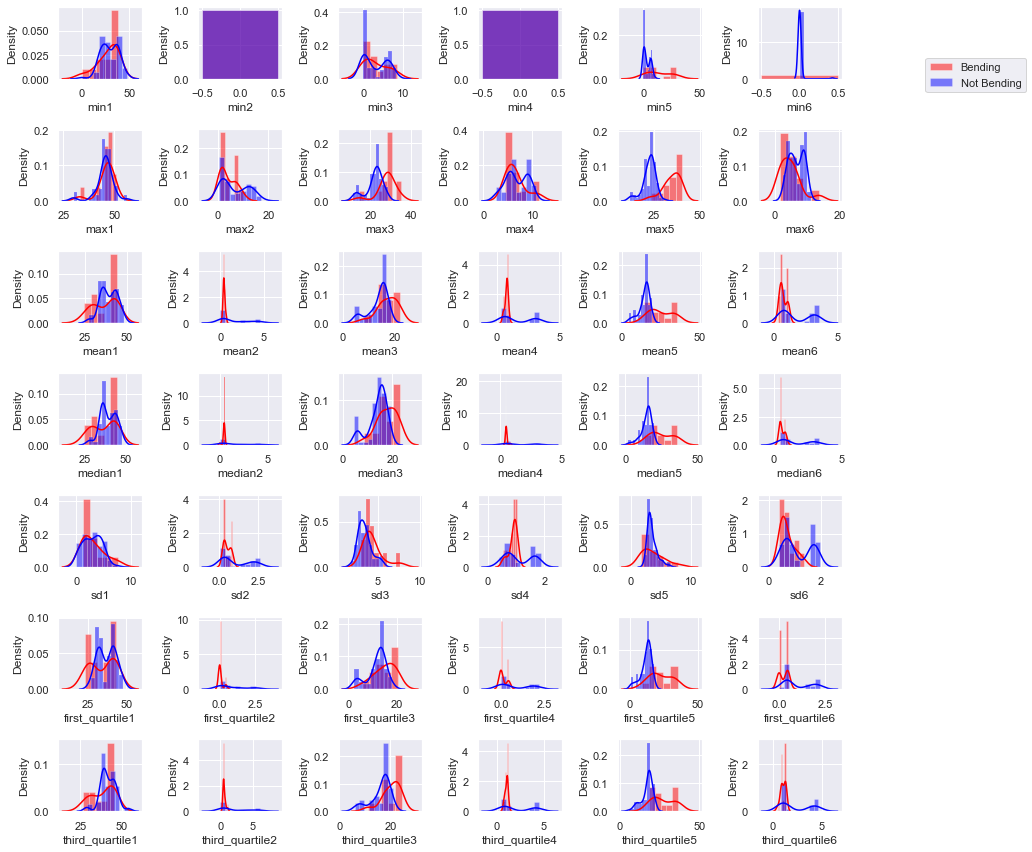

In [1584]:
features = ['min','max','mean','median','sd','first_quartile','third_quartile']
# https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
# making plot for useful features as suggested on piazza
plt.figure(figsize=(12,12))
for i, ft in enumerate(features, start =1):
    for j in range(1,7):    
        plt.subplot(len(features), 6, 6*i+j-6)
        sns.histplot(bend_train.loc[bend_train['bending']== 1][ft + str(j)] ,
                     kde = True,
                     color="red",
                     stat="density",
                     edgecolor=(1, 1, 1, .4),
                     kde_kws=dict(cut=3),
                     label="Bending")
        sns.histplot(bend_train.loc[bend_train['bending']== 0][ft + str(j)], 
                     kde = True,
                     color="blue", 
                     stat="density",
                     kde_kws=dict(cut=3),
                     edgecolor=(1, 1, 1, .4),
                     label='Not Bending')
print("Different features analysis: ")
plt.tight_layout()
plt.legend(loc=(2,10))
plt.show()

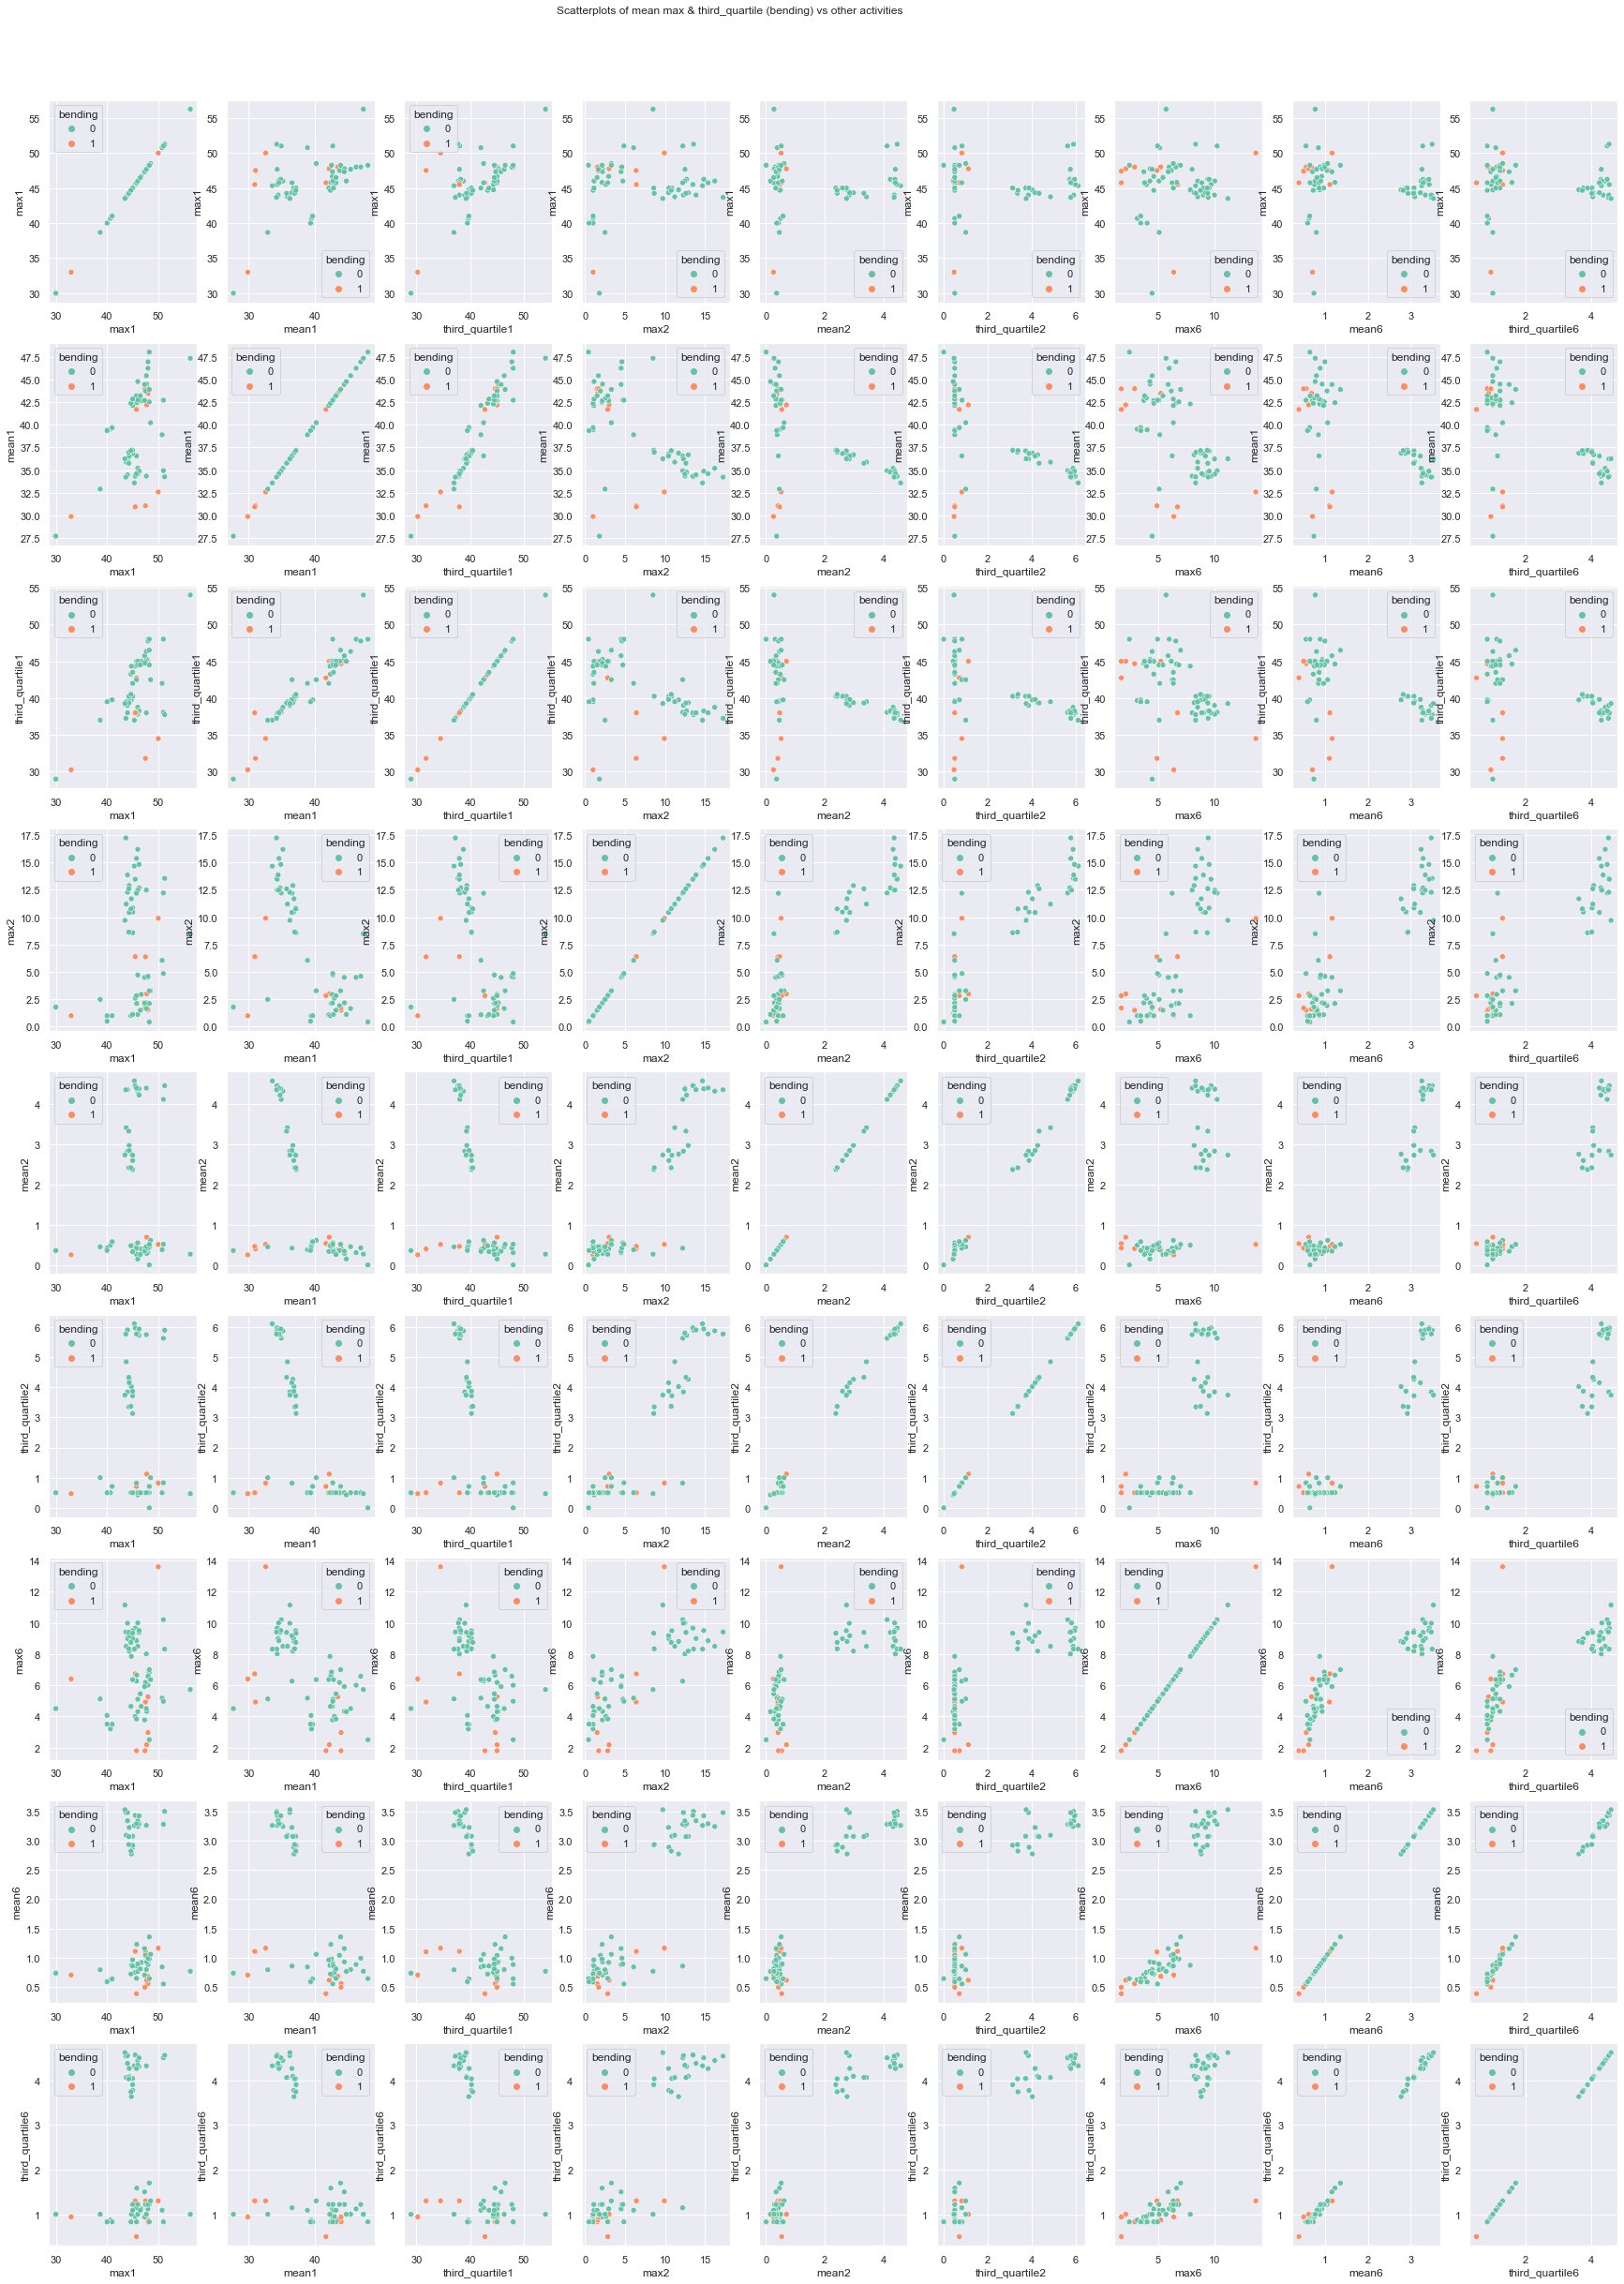

In [1585]:
series = [1,2,6]
stat = ['max','mean','third_quartile']
sel_features = [j+str(i) for i in series for j in stat]
bend_train = new_train_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]
bend_train = bend_train.drop(['activity'], axis=1)

def plots(data, features, row, col, row_size, col_size):
    if features[-1] != 'bending':
        features.append('bending')
    data = data[features]
    # print(data)
    main=[]
    for i in range(0,len(data.columns)-1):
        for j in range(0,len(data.columns)-1):
            main.append([features[i], features[j]])    
    plt.close()
    fig, axs = plt.subplots(nrows= row, ncols=col, figsize=(row_size,col_size))
    k=0
    for i in range(0,col):
        for j in range(0,row):
            sns.set(font_scale=1)
            plt.subplots_adjust(top=0.92)
            scatter_plot = sns.scatterplot(data=data, x=main[k][0], y=main[k][1], hue="bending", ax=axs[j][i], palette="Set2")
            plt.title("Scatterplots of mean max & third_quartile (bending) vs other activities", y=11, x = -5)
            k+=1  
    plt.show()
plots(bend_train, sel_features, 9, 9, 30, 40)

In [1586]:
# with activity
feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
all_feat = [j+str(i) for i in range(1,13) for j in feature_names]
all_feat.append('activity')
all_feat_data = load_data(all_set, all_feat, 2)
print(all_feat_data)

# bend train 0 or 1
stat = ['max','mean','third_quartile']
series = [1,2,3,4,11,12]
sel_features2 = [j+str(i) for i in  series for j in stat]
bend_train_data = all_feat_data
bend_train_data['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train_data['activity'].to_list()]

bend_train_data = bend_train_data.drop(['activity'], axis=1)
bend_train_data

     min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.67  45.00  43.486208    43.71  1.279302          42.3300   
1   39.00  48.00  44.117042    45.00  1.357000          43.5000   
2   33.75  47.75  43.278875    45.00  3.466111          42.0000   
3   33.00  45.75  41.621208    42.33  3.112140          39.6525   
4   38.00  42.33  40.946958    41.25  1.100662          40.3100   
..    ...    ...        ...      ...       ...              ...   
83  20.00  44.25  35.692167    35.50  4.633910          33.0000   
84  24.25  45.00  36.954208    36.00  3.764968          34.2500   
85  27.00  42.67  36.342750    36.75  3.640886          33.6700   
86  26.25  43.40  36.865417    36.25  3.455571          34.3100   
87  27.75  44.00  37.144583    36.67  3.796850          34.0000   

    third_quartile1   min2   max2      mean2  ...  first_quartile11  \
0             44.50  36.25  48.00  44.452042  ...            0.0000   
1             45.00  37.00  46.50  42.792875  ...    

,min1,max1,mean1,median1,sd1,first_quartile1,third_quartile1,min2,max2,mean2,...,first_quartile11,third_quartile11,min12,max12,mean12,median12,sd12,first_quartile12,third_quartile12,bending
0,36.67,45.00,43.486208,43.71,1.279302,42.3300,44.50,36.25,48.00,44.452042,...,0.0000,0.8300,0.0,2.96,0.585750,0.50,0.486900,0.4225,0.8300,1
1,39.00,48.00,44.117042,45.00,1.357000,43.5000,45.00,37.00,46.50,42.792875,...,0.4300,1.1200,0.0,4.06,0.543875,0.50,0.472458,0.4300,0.7100,1
2,33.75,47.75,43.278875,45.00,3.466111,42.0000,45.25,33.00,46.00,41.080750,...,0.0000,1.2200,0.0,2.18,0.586083,0.47,0.490847,0.0000,0.8700,1
3,33.00,45.75,41.621208,42.33,3.112140,39.6525,44.25,39.25,43.67,41.734917,...,0.0000,0.7100,0.0,1.50,0.347500,0.43,0.362386,0.0000,0.5000,1
4,38.00,42.33,40.946958,41.25,1.100662,40.3100,42.00,37.25,45.00,40.302625,...,0.0000,1.3000,0.0,1.92,0.552167,0.43,0.509430,0.0000,0.9400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,20.00,44.25,35.692167,35.50,4.633910,33.0000,39.25,18.50,44.00,35.812542,...,1.7900,4.3500,0.0,8.81,2.966917,2.59,1.708491,1.8525,3.7400,0
84,24.25,45.00,36.954208,36.00,3.764968,34.2500,40.25,29.00,44.67,37.399875,...,1.7525,3.9375,0.0,9.34,2.838083,2.45,1.886811,1.3825,3.8325,0
85,27.00,42.67,36.342750,36.75,3.640886,33.6700,39.00,23.33,43.50,36.145417,...,2.2525,4.7025,0.0,11.15,3.513250,3.08,1.974270,2.1700,4.5000,0
86,26.25,43.40,36.865417,36.25,3.455571,34.3100,40.00,29.25,44.25,37.049500,...,1.6550,4.0375,0.0,8.34,2.904458,2.57,1.606436,1.6900,3.7700,0


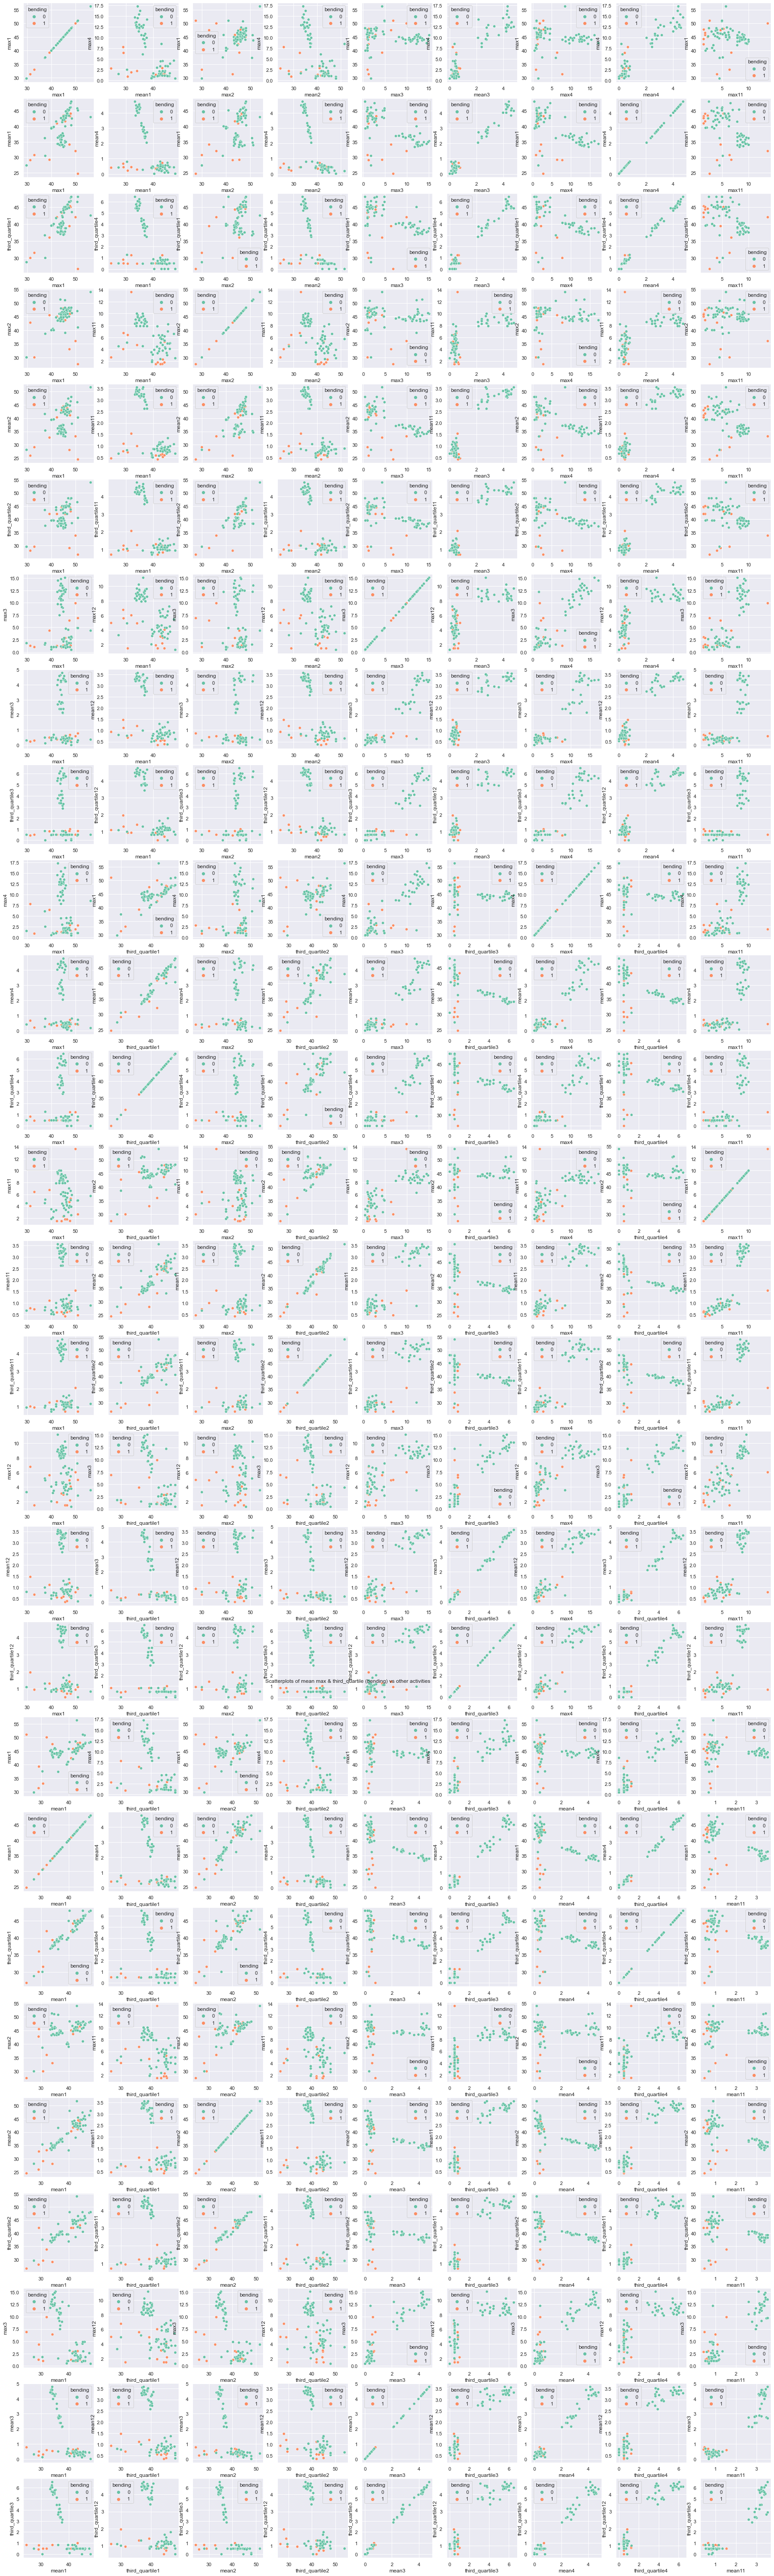

In [1595]:
plots(bend_train_data, sel_features2, 27, 9, 30, 100)

#### __iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.__

In [1588]:
def downsampling(data):
    bending_1 = data.loc[data['bending'] == 1]
    bending_0 = data.loc[data['bending'] == 0]
        
    # Finding the min and max count of each label
    min_count = min(bending_1.shape[0], bending_0.shape[0])
    max_count = max(bending_1.shape[0], bending_0.shape[0])
        
    # Finding the major sample class
    max_bending = 1 if bending_1.shape[0] > bending_0.shape[0] else 0
        
    # Dividing into minor and major samples
    major_sample = data.loc[data['bending'] == max_bending]
    minor_sample = data.loc[data['bending'] != max_bending]
        
    # Resampling the major_sample
    major_sample = resample(major_sample, n_samples = min_count * 3, replace=True, random_state=7)
        
    data = pd.concat([minor_sample, major_sample], ignore_index=True)
    return data

In [1589]:
def logisticRegressionCV(train_files, k, L, overSample=False, penalty='none'):    
    feature_names_lcv = ['min','max','mean','median','sd','first_quartile','third_quartile']
    features_lcv = [j+str(i) for i in range(1,6*L+1) for j in feature_names_lcv]
    features_lcv.append('activity')
    
    train_lcv = load_data(train_files, features_lcv, L)
    train_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in train_lcv['activity'].to_list()]
    train_lcv = train_lcv.drop(['activity'], axis=1)
    
    #Using DownSampling technique
    if overSample:
        train_lcv = downsampling(train_lcv)
    
    feature_names_lcv_updated = ['max','mean','third_quartile']
    features_lcv_updated = [j+str(i) for i in range(1,6*L+1) for j in feature_names_lcv_updated]
    features_lcv_updated.append('bending')
    
    train_lcv = train_lcv[features_lcv_updated]
    
    train_lcv_X = train_lcv.iloc[:,:-1]
    train_lcv_Y = train_lcv.iloc[:,-1]
    
    stratified_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=7)
    lr_model = LogisticRegression(penalty=penalty, solver='lbfgs')
    feature_selector = RFECV(estimator=lr_model, cv=stratified_cv)
    feature_selector.fit(train_lcv_X, train_lcv_Y)
    
    return feature_selector, lr_model

In [1590]:
def get_selected_features(lcv_result, overSample=False):
    # Best L
    best_pair = lcv_result.loc[lcv_result['score'] == max(lcv_result['score'])]
    best_L = best_pair['L'].to_list()[0]
    
    # Feature names for best L
    feature_names_best_lcv = ['max','mean','third_quartile']
    features_best_lcv = [j+str(i) for i in range(1,6*best_L+1) for j in feature_names_best_lcv]

    # Selected features for best L
    feature_selector, lr_model = logisticRegressionCV(train_set, 5, best_L, overSample=overSample)
    selected_features = [f for i, f in enumerate(features_best_lcv) if feature_selector.support_[i]]
    
    if overSample:
        eature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
        features_load = [j+str(i) for i in range(1,6*best_L+1) for j in feature_names]
        features_load.append('activity')
        data_lcv = load_data(train_set, features_load, best_L)
        data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
        data_lcv = data_lcv.drop(['activity'], axis=1)
        
        bending_1 = data_lcv.loc[data_lcv['bending'] == 1]
        bending_0 = data_lcv.loc[data_lcv['bending'] == 0]
        
        pi = bending_1.shape[0] / (bending_1.shape[0] + bending_0.shape[0])
        pi1 = 1 / 4
        feature_selector.estimator_.intercept_ += pi/(1-pi) + pi1/(1-pi1)

    return selected_features, best_L, lr_model 

In [1591]:
def get_data_splits(data, best_L, overSample=False):
    feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
    features_load = [j+str(i) for i in range(1,6*best_L+1) for j in feature_names]
    features_load.append('activity')
    
    data_lcv = load_data(data, features_load, best_L)
    data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
    data_lcv = data_lcv.drop(['activity'], axis=1)
    
    if overSample:
        data_lcv = downsampling(data_lcv)
    
    data_lcv_X = data_lcv.iloc[:,:-1]
    data_lcv_X = data_lcv_X[selected_features]
    data_lcv_Y = data_lcv.iloc[:,-1]
    
    return data_lcv_X, data_lcv_Y

In [1592]:
def c_matrix(lr_model, data_X, data_Y):
    lr_model.fit(data_X, data_Y)
    predict_Y = lr_model.predict(data_X)
    matrix = confusion_matrix(data_Y, predict_Y)
    return matrix

In [1593]:
def roc_auc(data_X, data_Y, lr_model, data_type):
    #ROC and AUC
    predict_Y_prob_estimates = lr_model.predict_proba(data_X)
    
    #predictY_prob_estimates[:, 1] - indicates getting the positive label estimates
    fpr, tpr, thresholds = roc_curve(data_Y, predict_Y_prob_estimates[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    plt.close()
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, 'b', label="Area Under Curve(AUC): {}".format(roc_auc))
    plt.plot([0,1], [0,1], 'k--')

    plt.title('ROC Curve for {} data'.format(data_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.grid()
    plt.show()

In [1594]:
# lcv_result = pd.DataFrame(columns=['L', 'p','score'])

# for i in tqdm(range(1,21)):
#     train_test_seg=[]
#     features_selected, lr_model = logisticRegressionCV(train_set, 5, i)
#     train_test_seg.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
#     df_new = pd.Series(train_test_seg, index = ['L', 'p', 'score'])
#     lcv_result = lcv_result.append(df_new, ignore_index=True)
#     lcv_result['L'] = lcv_result['L'].astype(int)
#     lcv_result['p'] = lcv_result['p'].astype(int)

# lcv_result